# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Importing the libraries :

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

## Loading dataset :

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

filtered_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [4]:
filtered_data.shape

(364171, 12)

In [5]:
sample_data = filtered_data.sample(n = 5000)
sample_data['Score'].value_counts()

positive    4226
negative     774
Name: Score, dtype: int64

In [6]:
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
59519,81779,88934,B000F3WS7K,A12AL2FG65IZSP,Brian Suwada,1,1,positive,1269216000,Quite Simply......,The very best black tea there is! I agree that...,b'best black tea agre good black tea consist d...
101897,142231,154378,B000LRH58W,A503L9ATZFFXM,"Harvey N. Moss ""Small business owner""",3,4,positive,1305504000,Gift - received raves,Given as a gift to my parents. They said it wa...,b'given gift parent said best halvah ever orde...


## Time Based Splitting :

In [7]:
# Sorting the sample data using Time column
sorted_sample = sample_data.sort_values(by='Time')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
6956,39671,43130,B0000W2SZS,A2BETN6Y2DEFZ1,Catnip,11,11,positive,1069459200,"Imparts wonderful, light flavor to dishes","I discovered these oils years ago, bought one ...",b'discov oil year ago bought one flavor thunde...
4237,175209,190013,B0000DGG1U,A28SJYEFR84MU1,L Flores,18,18,positive,1074556800,Beautiful!,I received this tree only 3 days after I order...,b'receiv tree day order beauti nice fat trunk ...


In [8]:
# Getting the Labels i.e the Score out of the dataframe.
y = sorted_sample['Score']
# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
sorted_sample = sorted_sample.drop(columns='Score')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
6956,39671,43130,B0000W2SZS,A2BETN6Y2DEFZ1,Catnip,11,11,1069459200,"Imparts wonderful, light flavor to dishes","I discovered these oils years ago, bought one ...",b'discov oil year ago bought one flavor thunde...
4237,175209,190013,B0000DGG1U,A28SJYEFR84MU1,L Flores,18,18,1074556800,Beautiful!,I received this tree only 3 days after I order...,b'receiv tree day order beauti nice fat trunk ...


In [9]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


## Bag of words :

In [10]:
count_vect = CountVectorizer()
bow_train= count_vect.fit_transform(x_train['CleanedText'].values)
bow_train = bow_train.todense()
bow_train.shape

(3000, 7402)

In [11]:
bow_test = count_vect.transform(x_test['CleanedText'].values)
bow_test = bow_test.todense()
bow_test.shape

(2000, 7402)

### Cross-Validation to find alpha :

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    scores = cross_val_score(clf, bow_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

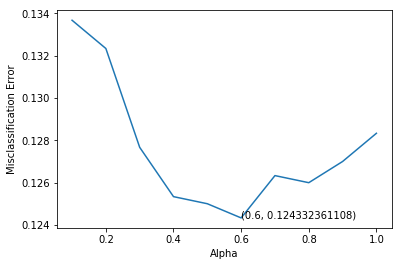

In [22]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

> So the misclassification error obtained is minimum for alpha = 0.6

### Feature selection :
> Getting most important words for +ve class and most important words for negative class.

In [24]:
# Creating the model with our best alpha.
clf = MultinomialNB(alpha = 0.6)
clf.fit(bow_train, y_train)

MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True)

In [26]:
# Log of probabilities is gien by below function. Every feature has a probability for each classes, in our class classes = 2.
clf.feature_log_prob_.shape #since class = 2 hence only 2 rows.

(2, 7402)

In [33]:
# Getting feature names and log probabilities and creating a dataframe out of them.
feat_names = count_vect.get_feature_names()
features = pd.DataFrame(data = clf.feature_log_prob_.T,index=feat_names, columns=['Negative', 'Positive'])
features.head()

,Negative,Positive
aaa,-10.451330,-11.030112
ab,-10.451330,-10.219182
abd,-10.451330,-11.030112
abdomin,-8.984992,-12.010941
abil,-9.470500,-9.974059


In [35]:
# Sorting first on Positive column to get 10 most important words.
features.sort_values(by='Positive', ascending=False)[0:10]

,Negative,Positive
like,-4.690327,-4.471383
tast,-4.432736,-4.575897
flavor,-5.030795,-4.650413
great,-6.142770,-4.669674
good,-5.309666,-4.707098
love,-5.615048,-4.720649
one,-4.987498,-4.788862
use,-5.380331,-4.819763
tea,-5.207820,-4.851649
product,-4.629270,-4.894006


In [36]:
features.sort_values(by='Negative', ascending=False)[0:10]

,Negative,Positive
tast,-4.432736,-4.575897
product,-4.629270,-4.894006
like,-4.690327,-4.471383
one,-4.987498,-4.788862
flavor,-5.030795,-4.650413
would,-5.115395,-5.434936
tri,-5.123453,-4.971281
tea,-5.207820,-4.851649
amazon,-5.234584,-5.453690
good,-5.309666,-4.707098


> We see that most of the important words are common to both classes, one reason could be because we are not considering n-grams and for negative classes maybe the word is present as 'not like' but since we are not using 2-grams we take only individual words so it is being considered as important for both the classes.

### Plotting Confusion matrix :

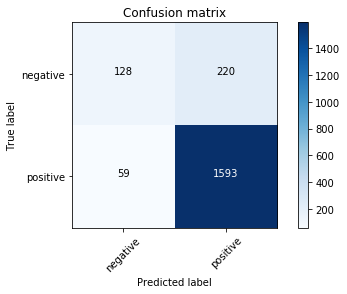

In [39]:
# Code from sklearn confusion matrix page -
import itertools
y_pred = clf.predict(bow_test)
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix(y_test, y_pred), ["negative", "positive"])
plt.show()

#### Calculating ratios :

In [58]:
TPR = (1593 * 1.0) / (y_test[y_test == 'positive'].count())
TNR = (128 * 1.0) / (y_test[y_test == 'negative'].count())
FPR = (220 * 1.0) / (y_test[y_test == 'negative'].count())
FNR = (59 * 1.0) / (y_test[y_test == 'positive'].count())

print ("True Positive Rate -> ", TPR,
      "\nTrue Negative Rate -> ", TNR,
      "\nFalse Positive Rate -> ", FPR,
      "\nFalse Negative Rate -> ", FNR)

True Positive Rate ->  0.964285714286 
True Negative Rate ->  0.367816091954 
False Positive Rate ->  0.632183908046 
False Negative Rate ->  0.0357142857143


> The model has high TPR which is good but has a low TNR and high FPR which makes this model a bad one.

### Metrics on Test Data :

In [59]:
acc = accuracy_score(y_test, y_pred)
print ("The accuracy for Multinomial Naive Bayes using an alpha of 0.6 is -> ", acc)

The accuracy for Multinomial Naive Bayes using an alpha of 0.6 is ->  0.8605


In [60]:
from sklearn.metrics import precision_recall_fscore_support

In [68]:
prec, rec, a, b = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("Precision Score -> ", prec,"\nRecall Score -> ", rec)

Precision Score ->  0.8605 
Recall Score ->  0.8605


In [69]:
print ("F1 Score -> ", (2 * prec * rec / (prec + rec)))

F1 Score ->  0.8605


## TF-IDF :

In [70]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tfidf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_train = tfidf_train.todense()
tfidf_train.shape

(3000, 85898)

In [71]:
tfidf_test = tfidf_vect.transform(x_test['CleanedText'].values)
tfidf_test = tfidf_test.todense()
tfidf_test.shape

(2000, 85898)

### Cross Validation to find alpha :

In [72]:
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [75]:
cv_scores = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    scores = cross_val_score(clf, tfidf_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

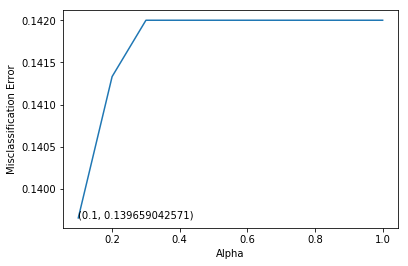

In [76]:
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

> Min error is obtained for alpha = 0.1.

### Feature Selection :
> Getting most important words for +ve class and -ve class.

In [77]:
# Creating the model with our best alpha.
clf = MultinomialNB(alpha = 0.1)
clf.fit(tfidf_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [78]:
# Getting feature names and log probabilities and creating a dataframe out of them.
feat_names = tfidf_vect.get_feature_names()
features = pd.DataFrame(data = clf.feature_log_prob_.T,index=feat_names, columns=['Negative', 'Positive'])
features.head()

,Negative,Positive
aaa,-11.669073,-11.479496
ab,-11.669073,-11.151035
ab fine,-11.669073,-11.830466
ab one,-11.669073,-11.434124
abd,-11.669073,-11.135343


In [79]:
# Sorting first on Positive column to get 10 most important words.
features.sort_values(by='Positive', ascending=False)[0:10]

,Negative,Positive
great,-8.713914,-6.375652
love,-8.287072,-6.477421
like,-7.387146,-6.499648
tea,-7.820941,-6.500962
tast,-7.087553,-6.509891
good,-7.935266,-6.542838
flavor,-7.578243,-6.570028
coffe,-7.870040,-6.581231
product,-7.304592,-6.660622
use,-8.047927,-6.699212


In [82]:
features.sort_values(by='Negative', ascending=False)[0:10]

,Negative,Positive
tast,-7.087553,-6.509891
product,-7.304592,-6.660622
like,-7.387146,-6.499648
would,-7.572042,-7.216689
flavor,-7.578243,-6.570028
one,-7.645971,-6.755972
order,-7.679922,-7.149820
amazon,-7.724067,-7.108205
tri,-7.731348,-6.834671
box,-7.735307,-7.525515


> Above are the most important words obtained when using TFIDF.

### Plotting Confusion matrix :

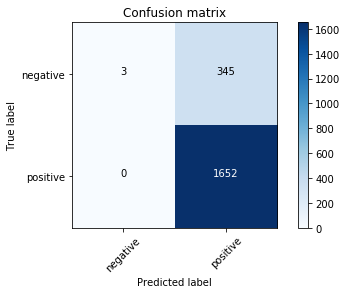

In [84]:
y_pred = clf.predict(tfidf_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ["negative", "positive"])
plt.show()

In [85]:
TPR = (1652 * 1.0) / (y_test[y_test == 'positive'].count())
TNR = (3 * 1.0) / (y_test[y_test == 'negative'].count())
FPR = (345 * 1.0) / (y_test[y_test == 'negative'].count())
FNR = (0 * 1.0) / (y_test[y_test == 'positive'].count())

print ("True Positive Rate -> ", TPR,
      "\nTrue Negative Rate -> ", TNR,
      "\nFalse Positive Rate -> ", FPR,
      "\nFalse Negative Rate -> ", FNR)

True Positive Rate ->  1.0 
True Negative Rate ->  0.00862068965517 
False Positive Rate ->  0.991379310345 
False Negative Rate ->  0.0


> Looking at the ratios our TPR is high (equal to 1) but so is FPR which shows that the model is overfitting a lot.

### Metrics on Test Data :

In [86]:
acc = accuracy_score(y_test, y_pred)
print ("The accuracy for Multinomial Naive Bayes using an alpha of 0.6 is -> ", acc)

The accuracy for Multinomial Naive Bayes using an alpha of 0.6 is ->  0.8275


In [87]:
prec, rec, a, b = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("Precision Score -> ", prec,"\nRecall Score -> ", rec)

Precision Score ->  0.8275 
Recall Score ->  0.8275


In [88]:
print ("F1 Score -> ", (2 * prec * rec / (prec + rec)))

F1 Score ->  0.8275
